In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchsummary import summary
import os

In [2]:
DATA_DIR = 'data/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_RAW = True

device(type='cuda')

In [3]:
def random_transformation(im):
    """Randomly rotate or flip the image"""
    i = np.random.randint(8)
    if i == 0 :
        return im
    if i == 1 :
        return np.rot90(im, axes=(0,1), k=1)
    if i == 2 :
        return np.rot90(im, axes=(0,1), k=2)
    if i == 3 :
        return np.rot90(im, axes=(0,1), k=3)
    if i == 4:
        return np.flip(im, axis=1)
    if i == 5:
        return np.flip(np.rot90(im, axes=(0,1), k=1))
    if i == 6:
        return np.flip(np.rot90(im, axes=(0,1), k=2))
    if i == 7:
        return np.flip(np.rot90(im, axes=(0,1), k=3))

In [4]:
class HackathonDataset(Dataset):
    """Hackathon Dataset"""   
    
    def __init__(self, csv_file, root_dir, use_raw=False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with paths and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.use_raw = use_raw
        
    def __len__(self):
        return len(self.file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        img_file = self.file.iloc[idx]["image_file_name"]        
        if "22NCL" in img_file:
            img_dir= "guyane/guyane/"
        elif "28PCC" in img_file:
            img_dir = "saint_louis/saint_louis/"  
        elif "29SMD" in img_file:
            img_dir = "dataset_29SMD/dataset_29SMD/"  
        elif "29TNE" in img_file:
            img_dir = "dataset_29TNE/dataset_29TNE/"
        else:
            raise Exception('There is something wrong with image name')    
        image = np.load(self.root_dir + img_dir + img_file + ".npy")
        if self.use_raw:
            image_raw = np.load(self.root_dir + img_dir + img_file + "_RAW.npy")
            image = np.concatenate((image, image_raw), axis=0)
        if self.transform:
            image = random_transformation(image)  # Add a random permutation of the image
        image = np.moveaxis(image, -1, 0)  # Permute dimensions in order to have Cin, H, W instead of H, W, Cin
        image = image.astype(np.float32)  # We work with float (float32), not double (float64)
        target = self.file.iloc[idx]["z"]
        target = target.astype(np.float32)  # We work with float (float32), not double (float64)
        sample = {'image': image, 'z': target, "image_file_name": img_file}
        return sample

In [177]:
class Net(nn.Module):
    """Used Network"""

    def __init__(self, use_raw = False):
        self.use_raw = use_raw
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(8 if self.use_raw else 4, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
#         self.conv3 = nn.Conv2d(32, 256, 3, padding=1)
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6400, 1024)  
        self.relu4 = nn.ReLU()
#         self.fc2 = nn.Linear(1024, 128)
#         self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(1024, 1)
        self.relu6 = nn.ReLU()
        
    def forward(self, x):
        """Given a tensor X of shape (Batch_size, C_in, H, W), compute the output tensor, of shape (Batch_size, )"""
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.pool3(x)
        x = x.flatten(start_dim=1)  # Flatten the 3 last dimensions, keep the 1 dimension (batch_size)
        x = self.fc1(x)
        x = self.relu4(x)
#         x = self.fc2(x)
#         x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = x.flatten()  # The output dimension should be (Batch_size, ) and not (Batch_size, 1) 
        return x

In [178]:
n_epochs = 10
batch_size = 4  # High batch size often happen to not converge... So we use small batches, even if slower
pred_batch_size = 128  # There is no problem of convergence for training batch size

In [179]:
#========================NOTE============================
# We often have to reset the model, because it won't converge. I don't know why, but it is useful to know
# If the training loss is stuck around 22 and the validation loss is stuck around 10,
# reset the model by running this cell again, and relaunch training
#========================END Of NOTE=====================

dataset = HackathonDataset(DATA_DIR + 'mixed_train.csv', DATA_DIR, USE_RAW)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 2)
val_dataset = HackathonDataset(DATA_DIR + 'mixed_validation.csv', DATA_DIR, USE_RAW)
val_dataloader = DataLoader(val_dataset, batch_size=pred_batch_size, shuffle=False, num_workers=os.cpu_count() - 2)
model = Net(USE_RAW)
model.to(DEVICE)
criterion = nn.MSELoss()

In [180]:
summary(model, (4, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]             592
              ReLU-2           [-1, 16, 40, 40]               0
         MaxPool2d-3           [-1, 16, 20, 20]               0
            Conv2d-4           [-1, 64, 20, 20]           9,280
              ReLU-5           [-1, 64, 20, 20]               0
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Linear-7                 [-1, 1024]       6,554,624
              ReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 1]           1,025
             ReLU-10                    [-1, 1]               0
Total params: 6,565,521
Trainable params: 6,565,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.89
Params size (MB): 25.05
Estima

In [181]:
optimizer = torch.optim.Adam(model.parameters())

In [182]:
print_frequency = 5

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # Print Epoch
    print(f"Epoch {epoch + 1}/{n_epochs}")
    
    # Training loop
    for it, batch in enumerate(dataloader):
                
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward propagation through the network
        out = model(batch["image"].to(DEVICE))
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        train_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
        #=====Printing part======
        if (it+1)%(len(dataloader) // print_frequency) == 0:
            print(f"Number of sample viewed : {it*batch_size}")
            print(f"Current training loss : {np.mean(train_losses[-len(dataloader)//print_frequency:-1])}")
            
            # Validation loop
            for it, batch in enumerate(val_dataloader):
                        
                # Forward propagation through the network
                out = model(batch["image"].to(DEVICE))
                
                # Calculate the loss
                loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
                
                # Track batch loss
                val_losses.append(loss.item())

            print(f"Current validation loss : {np.mean(val_losses[-int(len(val_dataloader)*0.8):-1])}")

Epoch 1/10
Number of sample viewed : 11392
Current training loss : 7.356903092391538
Current validation loss : 7.161036724180687
Number of sample viewed : 22788
Current training loss : 6.347864931782072
Current validation loss : 4.118725740064786
Number of sample viewed : 34184
Current training loss : 6.064015159505675
Current validation loss : 7.257711733420064
Number of sample viewed : 45580
Current training loss : 5.9058134586361675
Current validation loss : 4.34438489459631
Number of sample viewed : 56976
Current training loss : 5.763047224714196
Current validation loss : 5.490688784854618
Epoch 2/10
Number of sample viewed : 11392
Current training loss : 5.735674105346642
Current validation loss : 4.801892030896164
Number of sample viewed : 22788
Current training loss : 5.574859148025429
Current validation loss : 4.233040696053993
Number of sample viewed : 34184
Current training loss : 5.544036002525659
Current validation loss : 3.588396638397157


KeyboardInterrupt: 

In [185]:
def smoothed_curves(tab, gamma=0.99):
    ret = [tab[min(len(tab)-1, 1000)]]
    for val in tab:
        ret.append(ret[-1]*gamma + val * (1-gamma))
    return ret

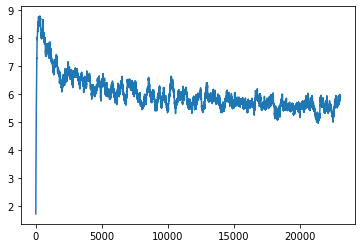

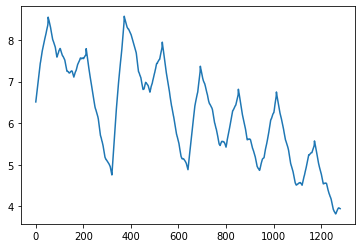

In [186]:
plt.plot(smoothed_curves(train_losses))
plt.show()
plt.plot(smoothed_curves(val_losses))
plt.show()

# Evaluation on Test Data

In [187]:
test_dataset = HackathonDataset(DATA_DIR + 'mixed_test.csv', DATA_DIR, USE_RAW)
test_dataloader = DataLoader(test_dataset, batch_size=pred_batch_size, shuffle=False, num_workers=os.cpu_count() - 2)
kaggle_df = pd.DataFrame(columns=['image_file_name', "z"])

In [188]:
data = []

for it, batch in enumerate(test_dataloader):
    out = model(batch["image"].to(DEVICE)).cpu().detach().numpy()
    img_file_names = batch["image_file_name"]
    for i in range(len(img_file_names)):
        data.append([img_file_names[i], out[i]])

kaggle_df = pd.DataFrame(data, columns=['image_id', 'predicted_z'])

In [189]:
kaggle_df.to_csv('predictions/prediction-' + datetime.now().strftime("%d-%m-%y:%H-%M") + '.csv', index=False)